In [1]:
# import packages and settings

import pandas as pd
import numpy as np
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import nltk
from nltk import word_tokenize    
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

from collections import Counter
from torch.utils.data import Dataset

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read data

train_data = pd.read_csv('TaskA-TrainingSet.csv')
valid_data = pd.read_csv('TaskA-ValidationSet.csv')

In [3]:
valid_data

,ID,section_header,dialogue
0,0,GENHX,Doctor: When did your pain begin? \r\nPatient:...
1,1,ROS,"Doctor: Hey, bud. What brings you in today? \r..."
2,2,PASTMEDICALHX,Doctor: Has anything changed in your medical h...
3,3,MEDICATIONS,Doctor: How've you been treating your acne? \r...
4,4,CC,Doctor: Have you been experiencing any mental ...
...,...,...,...
95,95,PROCEDURES,Doctor: How are you feeling? \r\nPatient: I a...
96,96,ROS,Doctor: How has our little man being doing?\r\...
97,97,IMAGING,"Doctor: Well, I have your E K G report, shows ..."
98,98,IMMUNIZATIONS,Doctor: Good news! No need for any shots today...


In [4]:
train_data

,ID,section_header,dialogue
0,0,GENHX,Doctor: What brings you back into the clinic t...
1,1,GENHX,Doctor: How're you feeling today? \r\nPatient...
2,2,GENHX,"Doctor: Hello, miss. What is the reason for yo..."
3,3,MEDICATIONS,Doctor: Are you taking any over the counter me...
4,4,CC,"Doctor: Hi, how are you? \r\nPatient: I burned..."
...,...,...,...
1196,1196,PASTSURGICAL,"Doctor: Good morning, sir. \r\nPatient: Good m..."
1197,1197,MEDICATIONS,"Doctor: Okay, so let's go over your medication..."
1198,1198,GENHX,"Doctor: How are you doing today, sir? \r\nPati..."
1199,1199,FAM/SOCHX,"Doctor: Hi, how's it going? \r\nPatient: Not t..."


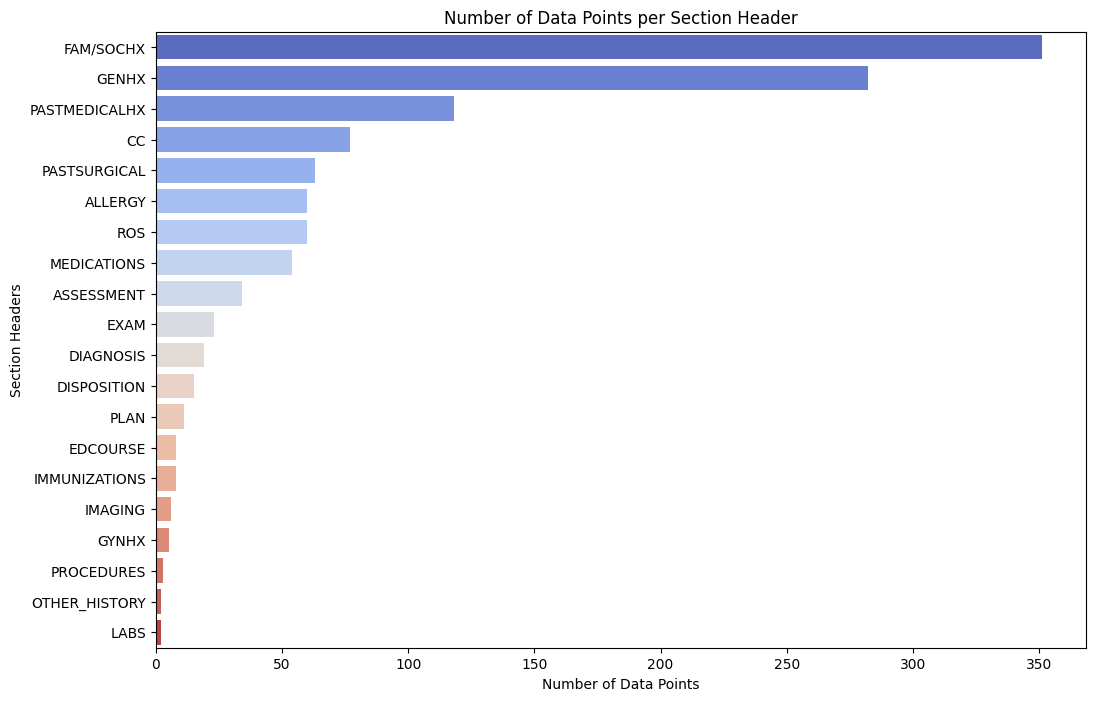

In [5]:
# EDA

# Plot the number of data points for each section header
plt.figure(figsize=(12, 8))
sns.countplot(data=train_data, y='section_header', order=train_data['section_header'].value_counts().index, palette='coolwarm')
plt.xlabel('Number of Data Points')
plt.ylabel('Section Headers')
plt.title('Number of Data Points per Section Header')
plt.show()


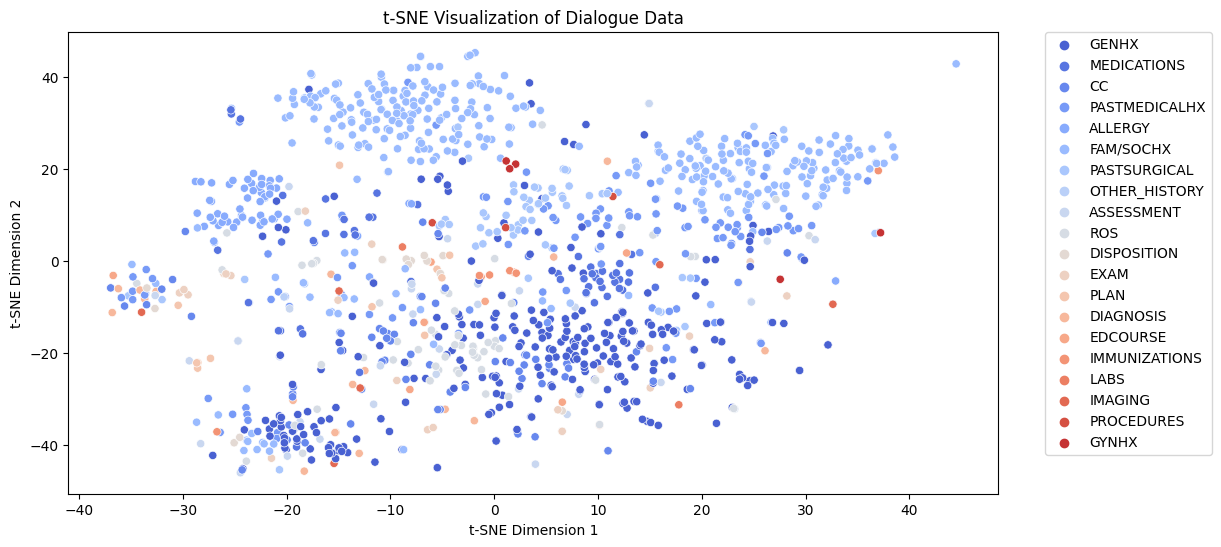

In [6]:
# Extract the dialogues and labels from the training data
dialogues = train_data['dialogue'].tolist()
labels = train_data['section_header'].tolist()

# Transform the text data into numerical vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
dialogue_vectors = tfidf_vectorizer.fit_transform(dialogues)

# Apply t-SNE 
tsne = TSNE(n_components=2, random_state=42)
dialogue_tsne = tsne.fit_transform(dialogue_vectors.toarray())

# Plot 
plt.figure(figsize=(12, 6))
sns.scatterplot(x=dialogue_tsne[:, 0], y=dialogue_tsne[:, 1], hue=labels, palette='coolwarm')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Dialogue Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [7]:
# count classes

np.unique(train_data['section_header'])

array(['ALLERGY', 'ASSESSMENT', 'CC', 'DIAGNOSIS', 'DISPOSITION',
       'EDCOURSE', 'EXAM', 'FAM/SOCHX', 'GENHX', 'GYNHX', 'IMAGING',
       'IMMUNIZATIONS', 'LABS', 'MEDICATIONS', 'OTHER_HISTORY',
       'PASTMEDICALHX', 'PASTSURGICAL', 'PLAN', 'PROCEDURES', 'ROS'],
      dtype=object)

In [8]:
len(np.unique(train_data['section_header']))

20

In [9]:
len(np.unique(valid_data['section_header']))

20

In [10]:
# assign train/ valid

X_train = train_data['dialogue']
y_train = train_data['section_header']

X_valid = valid_data['dialogue']
y_valid = valid_data['section_header']

In [11]:
# clean/ preprocess

In [12]:
stop_words = set(stopwords.words('english'))

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jiaqi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jiaqi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jiaqi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
def clean_data(text):
    
    # remove "Doctor:" and "Patient:" labels and timestamps
    text = re.sub(r"(Doctor|Patient|Guest_family):|\d{1,2}[:.]\d{1,2}\s?(AM|PM|am|pm)?", "", text)
    
    # Lowercase the text
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z\s]+", "", text)

    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join words back into a single string
    text = " ".join(words)

    return text


In [14]:
# preprocess the train data

X_train = X_train.apply(clean_data)
X_train

0       brings back clinic today miss came refill bloo...
1       howre feeling today terrible im worst headache...
2       hello miss reason visit today think wart back ...
3       taking counter medicine one prescribed alterna...
4          hi burned hand oh sorry wow yeah right arm yes
                              ...                        
1196    good morning sir good morning doctor begin eve...
1197    okay let go medication id like take help muscl...
1198    today sir honestly im pretty sick today ive go...
1199    hi hows going bad cant complain look like weat...
1200    look like nurse came asked everything ah every...
Name: dialogue, Length: 1201, dtype: object

In [15]:
X_valid = X_valid.apply(clean_data)
X_valid

0     pain begin ive low back pain eight year injury...
1     hey bud brings today rash upper arm torso star...
2     anything changed medical history since last vi...
3     howve treating acne dermatologist started accu...
4     experiencing mental difficulty confusion hallu...
                            ...                        
95    feeling well placed permanent pacemaker remove...
96    little man today well yesterday threw night na...
97    well e k g report show sinus tachycardia word ...
98    good news need shot today date immunization go...
99    im glad hear afib control id like start taking...
Name: dialogue, Length: 100, dtype: object

In [16]:
# + oversampler and run Clinical BERT - best result - F1: 0.75

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=20)

class Dialogue2TopicDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_length):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]

        # Encode
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0],
            'labels': torch.tensor(label, dtype=torch.long)
        }

# convert  

max_length = 307  

# Prepare label encoding
label_to_id = {label: idx for idx, label in enumerate(set(y_train))}
id_to_label = {idx: label for label, idx in label_to_id.items()}


# Oversampling 
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(
    np.array(X_train).reshape(-1, 1), y_train
)
X_train_resampled = X_train_resampled.ravel()

print("Before oversampling:", Counter(y_train))
print("After oversampling:", Counter(y_train_resampled))

# Encode label
y_train_ids = [label_to_id[label] for label in y_train_resampled]  
y_valid_ids = [label_to_id[label] for label in y_valid]

# convert dataset
train_dataset = Dialogue2TopicDataset(X_train_resampled, y_train_ids, tokenizer, max_length)  
valid_dataset = Dialogue2TopicDataset(X_valid, y_valid_ids, tokenizer, max_length)

# Define the perameters

training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,  
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    learning_rate=2e-5,  
    weight_decay=0.01,  
    save_strategy="no",
)

# metric

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

#  train model 

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# evaluation

evaluation_results = trainer.evaluate()
print(evaluation_results)

# report

predictions_output = trainer.predict(valid_dataset)
predicted_labels = predictions_output.predictions.argmax(-1)

y_valid_pred = [id_to_label[label_id] for label_id in predicted_labels]
y_valid_true = [id_to_label[label_id] for label_id in y_valid_ids]

report = classification_report(y_valid_true, y_valid_pred)
print(report)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Before oversampling: Counter({'FAM/SOCHX': 351, 'GENHX': 282, 'PASTMEDICALHX': 118, 'CC': 77, 'PASTSURGICAL': 63, 'ALLERGY': 60, 'ROS': 60, 'MEDICATIONS': 54, 'ASSESSMENT': 34, 'EXAM': 23, 'DIAGNOSIS': 19, 'DISPOSITION': 15, 'PLAN': 11, 'EDCOURSE': 8, 'IMMUNIZATIONS': 8, 'IMAGING': 6, 'GYNHX': 5, 'PROCEDURES': 3, 'OTHER_HISTORY': 2, 'LABS': 2})
After oversampling: Counter({'GENHX': 351, 'MEDICATIONS': 351, 'CC': 351, 'PASTMEDICALHX': 351, 'ALLERGY': 351, 'FAM/SOCHX': 351, 'PASTSURGICAL': 351, 'OTHER_HISTORY': 351, 'ASSESSMENT': 351, 'ROS': 351, 'DISPOSITION': 351, 'EXAM': 351, 'PLAN': 351, 'DIAGNOSIS': 351, 'EDCOURSE': 351, 'IMMUNIZATIONS': 351, 'LABS': 351, 'IMAGING': 351, 'PROCEDURES': 351, 'GYNHX': 351})


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.540900,1.142313,0.710000,0.715426,0.758130,0.710000
2,0.070200,1.301894,0.740000,0.735267,0.785804,0.740000
3,0.023600,1.329136,0.750000,0.734310,0.761803,0.750000


{'eval_loss': 1.3291363716125488, 'eval_accuracy': 0.75, 'eval_f1': 0.7343095238095239, 'eval_precision': 0.7618034188034187, 'eval_recall': 0.75, 'eval_runtime': 31.3129, 'eval_samples_per_second': 3.194, 'eval_steps_per_second': 0.415, 'epoch': 3.0}
               precision    recall  f1-score   support

      ALLERGY       1.00      0.50      0.67         4
   ASSESSMENT       0.33      0.25      0.29         4
           CC       0.60      0.75      0.67         4
    DIAGNOSIS       0.00      0.00      0.00         1
  DISPOSITION       0.20      0.50      0.29         2
     EDCOURSE       1.00      0.33      0.50         3
         EXAM       0.50      1.00      0.67         1
    FAM/SOCHX       0.81      0.95      0.88        22
        GENHX       0.80      0.80      0.80        20
        GYNHX       0.00      0.00      0.00         1
      IMAGING       1.00      1.00      1.00         1
IMMUNIZATIONS       1.00      1.00      1.00         1
         LABS       0.00      0.

In [20]:
# predict test labels

In [21]:
# test data
test_data = pd.read_csv("taskA_testset4participants_headers_inputConversations.csv")
test_data

,ID,dialogue
0,0,"Doctor: Hello, how are you today?\nPatient: No..."
1,1,Guest_family: My two and half year old son and...
2,2,"Doctor: Good afternoon, sir. My chart here say..."
3,3,Doctor: Do you have any known history of aller...
4,4,Doctor: Are you taking Macrodantin?\nPatient: ...
...,...,...
195,195,Doctor: Welcome back. How have you been feelin...
196,196,Doctor: Any fever?\nPatient: No.\nDoctor: Did ...
197,197,Doctor: She was in the E R last week with a B ...
198,198,Doctor: Any surgeries in the past?\nPatient: U...


In [22]:
# Assign test data
X_test = test_data['dialogue']

In [23]:
# Preprocess test data
X_test = X_test.apply(clean_data)
X_test

0      hello today good happened lot congestion also ...
1      two half year old son five half year old steps...
2      good afternoon sir chart say fifty one year ol...
3                     known history allergy dont allergy
4      taking macrodantin yes urine infection right y...
                             ...                        
195    welcome back feeling well symptom become worse...
196    fever notice change weight really weakness bod...
197    e r last week b c zero point ten guestclinicia...
198    surgery past um gastric bypass surgery recent ...
199    family medical health problem dad high blood p...
Name: dialogue, Length: 200, dtype: object

In [24]:
# Create test dataset (without labels)
class Dialogue2TopicTestDataset(Dataset):
    def __init__(self, X, tokenizer, max_length):
        self.X = X
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]

        # Encode
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0]
        }

In [25]:
# convert test data

test_dataset = Dialogue2TopicTestDataset(X_test, tokenizer, max_length)
test_dataset

In [26]:
# Predict test data
test_predictions_output = trainer.predict(test_dataset)
test_predicted_labels = test_predictions_output.predictions.argmax(-1)

# Convert label ids back to original labels
y_test_pred = [id_to_label[label_id] for label_id in test_predicted_labels]
y_test_pred

['CC',
 'FAM/SOCHX',
 'GENHX',
 'ALLERGY',
 'MEDICATIONS',
 'PASTMEDICALHX',
 'ROS',
 'PASTSURGICAL',
 'GENHX',
 'PASTMEDICALHX',
 'PASTMEDICALHX',
 'FAM/SOCHX',
 'FAM/SOCHX',
 'MEDICATIONS',
 'FAM/SOCHX',
 'GYNHX',
 'GENHX',
 'CC',
 'PASTMEDICALHX',
 'ASSESSMENT',
 'IMMUNIZATIONS',
 'PASTSURGICAL',
 'PASTMEDICALHX',
 'CC',
 'PASTMEDICALHX',
 'FAM/SOCHX',
 'FAM/SOCHX',
 'DISPOSITION',
 'GENHX',
 'FAM/SOCHX',
 'ALLERGY',
 'ROS',
 'ASSESSMENT',
 'PASTSURGICAL',
 'PASTSURGICAL',
 'FAM/SOCHX',
 'GENHX',
 'FAM/SOCHX',
 'CC',
 'PASTMEDICALHX',
 'MEDICATIONS',
 'ASSESSMENT',
 'FAM/SOCHX',
 'FAM/SOCHX',
 'PASTMEDICALHX',
 'FAM/SOCHX',
 'GENHX',
 'CC',
 'PASTMEDICALHX',
 'FAM/SOCHX',
 'PASTMEDICALHX',
 'CC',
 'GENHX',
 'GENHX',
 'FAM/SOCHX',
 'FAM/SOCHX',
 'GENHX',
 'CC',
 'FAM/SOCHX',
 'ALLERGY',
 'FAM/SOCHX',
 'GENHX',
 'PASTMEDICALHX',
 'GENHX',
 'ASSESSMENT',
 'PLAN',
 'GENHX',
 'GENHX',
 'CC',
 'GENHX',
 'PLAN',
 'FAM/SOCHX',
 'GENHX',
 'FAM/SOCHX',
 'MEDICATIONS',
 'GENHX',
 'DIAGNOSIS',


In [27]:
# Create the df 
output_df = pd.DataFrame({'TestID': test_data['ID'], 'SystemOutput': y_test_pred})

# CSV file
output_df.to_csv('taskA_StellElla_Stars_run1_mediqaSum.csv', index=False)

In [28]:
# ! pip freeze > requirements.txt

In [29]:
import argparse
import pandas
import numpy
import tqdm
import imblearn
import matplotlib
import nltk
import torch
import transformers
import keras
import sklearn

print(f"argparse: {argparse.__version__}")
print(f"pandas: {pandas.__version__}")
print(f"numpy: {numpy.__version__}")
print(f"tqdm: {tqdm.__version__}")
print(f"imbalanced-learn: {imblearn.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"nltk: {nltk.__version__}")
print(f"torch: {torch.__version__}")
print(f"transformers: {transformers.__version__}")
print(f"keras: {keras.__version__}")
print(f"scikit-learn: {sklearn.__version__}")

argparse: 1.1
pandas: 1.5.0
numpy: 1.21.5
tqdm: 4.64.1
imbalanced-learn: 0.8.0
matplotlib: 3.6.0
nltk: 3.7
torch: 1.12.1+cpu
transformers: 4.28.1
keras: 2.11.0
scikit-learn: 0.24.2


In [30]:
import sys
print(sys.executable)


C:\Users\Jiaqi\anaconda3\new\python.exe
